This is a supplementary sage notebook for the paper "Extremal quasimodular forms and modular form inequalities for optimal sphere packing". This code checks the modular form identities appearing in the paper.

# Level 1 quasimodular forms

Quasimodular forms of level 1 (or more generally, level $\Gamma_0(N)$ or $\Gamma_1(N)$) is implemented in Sage, mostly by David Ayotte. We define some utility functions that help us to study the quasimodular forms easily.

In [1]:
# Level 1 quasimodular forms
QM = QuasiModularForms(1)
E2, E4, E6 = QM.0, QM.1, QM.2  # generators, normalized as constant terms = 1
Disc = (1 / 1728) * (E4^3 - E6^2)  # discriminant form

# Depth
def qm_depth(qm):
    return qm.polynomial().degree(E2.polynomial())

# Fourier coefficients
def qm_coefficients(qm, prec=20):
    qexp = qm.q_expansion(prec)
    return q_expansion_to_list(qexp, prec)

def q_expansion_to_list(qexp, prec=20):
    return [qexp[i] for i in range(prec)]

# Iterative differentiation of quasimodular forms
def qm_derivative_fold(qm, k):
    if k == 0:
        return qm
    else:
        return qm_derivative_fold(qm.derivative(), k - 1)

# Serre derivative with given weight k
# If weight is not given, we use k = (weight - depth) that preserves depth.
def qm_serre_derivative(qm, k=None):
    if k is None:
        k = qm.weight() - qm_depth(qm)
    return qm.derivative() - E2 * qm * (k / 12)

# Iterative Serre derivative, which is 
# \partial_{k + 2(r-1)} \circ \partial_{k + 2(r-2)} \circ \cdots \circ \partial_{k} for given r >= 1.
def qm_serre_derivative_fold(qm, r, k=None):
    assert r >= 0
    if r == 0:
        return qm
    elif r == 1:
        return qm_serre_derivative(qm, k)
    else:
        if k is None:
            k = qm.weight() - qm_depth(qm)
        return qm_serre_derivative(qm_serre_derivative_fold(qm, r-1, k), k + 2 * (r-1))

# Dimension of the space of (genuine) modular forms of weight w and level 1
def dim_m(w):
    assert w % 2 == 0
    if w % 12 == 2:
        return w // 12
    else:
        return w // 12 + 1

# Dimension of the space of (genuine) modular forms of weight w, depth <= s and level 1
def dim_qm(w, s):
    assert w % 2 == 0
    assert s >= 0
    d = (w * (s + 1)) // 12
    d -= ((s + 1) // 6) * (s - 3 * ((s + 1) // 6) - 1)
    d += s // 6 + 1
    if (w * (s + 1)) % 12 == 2:
        d -= 1
    return d

# Basis of the space of quasimodular forms of given weight and depth, in terms of Eisenstein series
def qm_basis(w, s):
    basis = []
    for r in range(s + 1):
        w_ = w - 2 * r
        for i in range(w_ // 4 + 1):
            if (w_ - 4 * i) % 6 == 0:
                j = (w_ - 4 * i) // 6
                basis.append(E2^r * E4^i * E6^j)
    return basis

# Vanishing order at the cusp
def qm_cusp_order(qm):
    N = 1000
    c_ = qm_coefficients(qm, N)
    r = 0
    for i in range(N):
        if c_[i] != 0:
            break
        r += 1
    return r

# First nonzero Fourier coefficient
def qm_first_nonzero_coeff(qm):
    N = 1000
    c_ = qm_coefficients(qm, N)
    for i in range(N):
        if c_[i] != 0:
            return c_[i]

# Normalize to make the first nonzero coefficient as 1
def qm_normalize(qm):
    return qm / qm_first_nonzero_coeff(qm)

# Print q-expansion, weight, depth, cusp order, and its polynomial form
def print_qm(qm, name, prec=20):
    print(name + "\n")
    print("q_expansion", qm.q_expansion(prec), "\n")
    if qm.is_homogeneous():
        print("weight", qm.weight())
    else:
        print("weight", qm.weights_list())
    print("depth", qm_depth(qm))
    print("cusp order", qm_cusp_order(qm))
    print("polynomial", qm.polynomial().factor(), "\n")

For example, the following quasimodular forms appear as a part of the magic functions.

In [2]:
F_8d = (E2 * E4 - E6)^2
print_qm(F_8d, "F_8d")

F_24d = 49 * E2^2 * E4^3 - 25 * E2^2 * E6^2 - 48 * E2 * E4^2 * E6 - 25 * E4^4 + 49 * E4 * E6^2
print_qm(F_24d, "F_24d")

F_8d

q_expansion 518400*q^2 + 18662400*q^3 + 255052800*q^4 + 1870387200*q^5 + 9760435200*q^6 + 38755584000*q^7 + 129782476800*q^8 + 372202905600*q^9 + 967623667200*q^10 + 2263116672000*q^11 + 4995028684800*q^12 + 10180874188800*q^13 + 19989201254400*q^14 + 36921804134400*q^15 + 66489204326400*q^16 + 113850991411200*q^17 + 191997786758400*q^18 + 309769955251200*q^19 + O(q^20) 

weight 12
depth 2
cusp order 2
polynomial (-E2*E4 + E6)^2 

F_24d

q_expansion 3657830400*q^3 + 138997555200*q^4 + 2567796940800*q^5 + 27477621964800*q^6 + 203324160614400*q^7 + 1155903669043200*q^8 + 5339174090342400*q^9 + 21015084264652800*q^10 + 72521005100544000*q^11 + 224861553797529600*q^12 + 636227181370368000*q^13 + 1668067755850137600*q^14 + 4088240185030041600*q^15 + 9465006273911193600*q^16 + 20805434866660147200*q^17 + 43762572956919398400*q^18 + 88336945205133004800*q^19 + O(q^20) 

weight 16
depth 2
cusp order 3
polynomial 49*E2^2*E4^3 - 25*E2^2*E6^2 - 48*E2*E4^2*E6 - 25*E4^4 + 49*E4*E6^2 



For a given quasimodular form $F$ and a list of other forms $F_i$, the following function tries to express a linear expression $F = \sum_i c_i F_i$ using the first few Fourier coefficients.

In [3]:
def qm_find_lin_comb(qm, ls):
    w = qm.weight()
    s = qm_depth(qm)
    N = dim_qm(w, s)
    m = matrix([qm_coefficients(qm_, N) for qm_ in ls])
    c_ = vector(qm_coefficients(qm, N))
    x_ = m.solve_left(c_)
    r = sum(x_[j] * ls[j] for j in range(len(ls)))
    assert qm == r
    return x_

For example, the following code shows the identity $E_{10}' = \frac{5}{3}E_{4} E_{6}' + 576\Delta$.

In [4]:
E10 = E4 * E6
print_qm(E10.derivative(), "E_10'")
print(qm_find_lin_comb(E10.derivative(), [E4 * E6.derivative(), Disc]))

E_10'

q_expansion -264*q - 270864*q^2 - 15589728*q^3 - 277365792*q^4 - 2578126320*q^5 - 15995060928*q^6 - 74573467584*q^7 - 284022573120*q^8 - 920557851048*q^9 - 2645157604320*q^10 - 6847480097568*q^11 - 16379004749184*q^12 - 36394641851568*q^13 - 76512377741184*q^14 - 152243515448640*q^15 - 290839114879104*q^16 - 532222389723024*q^17 - 944492355175248*q^18 - 1618601492064480*q^19 + O(q^20) 

weight 12
depth 1
cusp order 1
polynomial (-1/6) * (-5*E2*E4*E6 + 3*E4^3 + 2*E6^2) 

(5/3, 576)


We also have a function to restrict a modular form as a function on the imaginary axis, i.e. the function $t \mapsto F(it)$.

In [5]:
def qm_to_func(qm, prec=100):
    t = var('t')
    c = qm.q_expansion(prec).list()
    func = c[0]
    for i in range(1, prec):
        func += c[i] * exp(-i * 2 * pi * t)
    return func

As an example, here is a plot of all the terms appearing in the definition of `F_24d`.

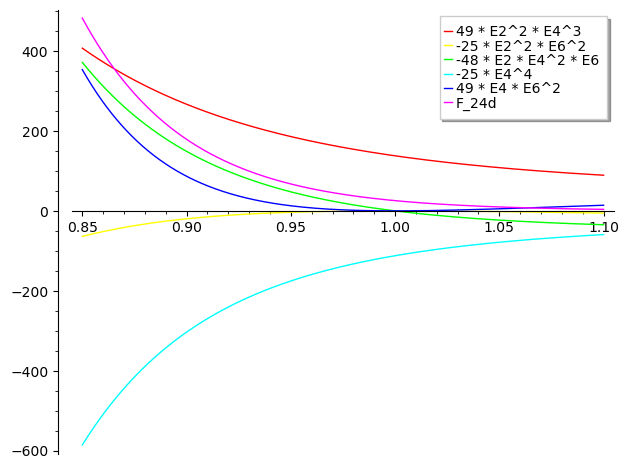

In [6]:
F_24d = 49 * E2^2 * E4^3 - 25 * E2^2 * E6^2 - 48 * E2 * E4^2 * E6 - 25 * E4^4 + 49 * E4 * E6^2
C1 = 49 * E2^2 * E4^3
C2 = - 25 * E2^2 * E6^2
C3 = - 48 * E2 * E4^2 * E6
C4 = - 25 * E4^4
C5 = 49 * E4 * E6^2

ls = [C1, C2, C3, C4, C5, F_24d]
names = ["49 * E2^2 * E4^3", "-25 * E2^2 * E6^2", "-48 * E2 * E4^2 * E6", "-25 * E4^4", "49 * E4 * E6^2", "F_24d"]
plots = [
    plot(qm_to_func(ls[i]), (t, 0.85, 1.1), color=rainbow(len(ls))[i], legend_label=names[i]) for i in range(len(ls))
]
show(sum(plots))

# Level 2 quasimodular forms

Level $\Gamma(2)$ quasimodular forms can be written as polynomial in $E_2$, $H_2 = \Theta_2^4$, $H_4 = \Theta_4^4$, where $\Theta_2$ and $\Theta_4$ are Jacobi thetanulle functions. We implement the ring of quasimodular forms of level $\Gamma(2)$ using this fact.

In [7]:
# E2_, E4_, E6_ are the usual Eisenstein series of level 1 and weight 2, 4, 6, but in the space of level 2 forms
QM2.<H2, H4, E2_> = QQ['H2,H4,E2']
E4_ = H2^2 + H2 * H4 + H4^2
E6_ = (H2 + 2 * H4) * (2 * H2 + H4) * (H4 - H2) / 2
Disc_ = H2^2 * (H2 + H4)^2 * H4^2 / 256


# Weight
def qm2_weight(qm):
    w = None
    for (a, b, e) in qm.dict().keys():
        if w is None:
            w = 2 * a + 2 * b + 2 * e
        else:
            assert w == 2 * a + 2 * b + 2 * e
    return w

# Depth
def qm2_depth(qm):
    dp = 0
    for (_, _, e) in qm.dict().keys():
        dp = max(e, dp)
    return dp

# Derivative of level 2 quasimodular form
def qm2_derivative(qm):
    r = QM2(0)
    for (a, b, e), coeff in qm.dict().items():
        r += (coeff / 6) * H2^a * H4^b * ((a - 2 * b) * H2 + (2 * a - b) * H4 + (a + b) * E2_) * E2_^e
        if e >= 1:
            r += coeff * H2^a * H4^b * e * E2_^(e-1) * (E2_^2 - E4_) / 12
    return r

# Serre derivative
def qm2_serre_derivative(qm, k=None):
    if k is None:
        # Serre derivative that preserves depth
        k = qm2_weight(qm) - qm2_depth(qm)
    return qm2_derivative(qm) - (k / 12) * E2_ * qm


# Iterative Serre derivative
def qm2_serre_derivative_fold(qm, r, k=None):
    assert r >= 0
    if r == 0:
        return qm
    elif r == 1:
        return qm2_serre_derivative(qm, k)
    else:
        if k is None:
            k = qm.weight() - qm2_depth(qm)
        return qm2_serre_derivative(qm2_serre_derivative_fold(qm, r-1, k), k + 2 * (r-1))

Level $\Gamma(2)$ quasimodular forms admit expansions in $q^{1/2}$ in general. The below functions give you an expansion in $q^{1/2}$, where the variable's name is `qh`.

In [8]:
# q-series
# Note that the variable `q` in the expansion is in fact e^(pi * i * z), which is `q^(1/2)`.
# The default precision is fixed (which is enough for our purpose), but you can increase it
prec = 80
qh = var('qh')  # q^1/2

def sigma(k, m):
    r = 0
    for i in range(1, k + 1):
        if k%i == 0:
            r += i^m
    return r

def r4(k):
    if k == 0:
        return 1
    elif k % 4 == 0:
        return 8 * sigma(k, 1) - 32 * sigma(k / 4, 1)
    else:
        return 8 * sigma(k, 1)

# q-series of Jacobi thetanulle functions
H3ser = 1
for i in range(1, prec):
    H3ser += r4(i) * qh^i
H4ser = 1
for i in range(1, prec):
    H4ser += (-1)^i * r4(i) * qh^i
H2ser = H3ser - H4ser

# q-series of Eisenstein series
E2ser = 1
for i in range(1, prec):
    E2ser -= 24 * sigma(i, 1) * qh^(2 * i)

E4ser = 1
for i in range(1, prec):
    E4ser += 240 * sigma(i, 3) * qh^(2 * i)
    
E6ser = 1
for i in range(1, prec):
    E6ser -= 504 * sigma(i, 5) * qh^(2 * i)

def qm2_q_series(qm, prec=20):
    # Recall that the series is in q^(1/2)
    r = 0
    H2ser_ = H2ser.series(qh, prec)
    H4ser_ = H4ser.series(qh, prec)
    E2ser_ = E2ser.series(qh, prec)
    for (a, b, e), coeff in qm.dict().items():
        r += coeff * H2ser_^a * H4ser_^b * E2ser_^e
    return r.series(qh, prec)

# Cusp order
def qm2_cusp_order(qm):
    N = 50
    c = qm2_q_series(qm, N).list()
    for i in range(N):
        if c[i] != 0:
            return i / 2

# First nonzero Fourier coefficient
def qm2_first_nonzero_coeff(qm):
    N = 100
    c = qm2_q_series(qm, N).list()
    for i in range(N):
        if c[i] != 0:
            return Rational(c[i])

def qm2_normalize(qm):
    return qm / qm2_first_nonzero_coeff(qm)

def print_qm2(qm, name, prec=30):
    print(name + "\n")
    print("q_expansion", qm2_q_series(qm, prec), "\n")
    print("weight", qm2_weight(qm))
    print("depth", qm2_depth(qm))
    print("cusp order", qm2_cusp_order(qm))
    print("polynomial", qm.factor(), "\n")

In [9]:
print_qm2(H2 + H4, "H3")  # Jacobi identity

H3

q_expansion 1 + 8*qh + 24*qh^2 + 32*qh^3 + 24*qh^4 + 48*qh^5 + 96*qh^6 + 64*qh^7 + 24*qh^8 + 104*qh^9 + 144*qh^10 + 96*qh^11 + 96*qh^12 + 112*qh^13 + 192*qh^14 + 192*qh^15 + 24*qh^16 + 144*qh^17 + 312*qh^18 + 160*qh^19 + 144*qh^20 + 256*qh^21 + 288*qh^22 + 192*qh^23 + 96*qh^24 + 248*qh^25 + 336*qh^26 + 320*qh^27 + 192*qh^28 + 240*qh^29 + Order(qh^30) 

weight 2
depth 0
cusp order 0
polynomial H2 + H4 



We can also define `qm2_find_lin_comb` for level $\Gamma(2)$ quasimodular forms.

In [10]:
def dim_m2(w):
    return w / 2 + 1

def dim_qm2(w, s=None):
    if s is None:
        s = w / 2
    d = 0
    for k in range(s + 1):
        d += dim_m2(w - 2 * k)
    return d

def qm2_find_lin_comb(qm, ls, prec=40):
    w = qm2_weight(qm)
    s = qm2_depth(qm)
    N = dim_qm2(w, s)
    m = matrix([qm2_q_series(qm_, N).list()[:N] for qm_ in ls])
    c_ = vector(qm2_q_series(qm, N).list())
    x_ = m.solve_left(c_)
    # check if we get the right result
    r = sum(Rational(x_[j]) * ls[j] for j in range(len(ls)))
    assert r == qm
    return x_

We can also embed a level $1$ form as a level $\Gamma(2)$ form.

In [11]:
# Rewrite level 1 quasimodular forms as level Gamma(2) forms
def l1_to_l2(qm):
    r = QM2(0)
    for (d2, d4, d6), coeff in qm.polynomial().dict().items():
        r += coeff * E2_^d2 * E4_^d4 * E6_^d6
    return r

In [12]:
assert l1_to_l2(E2) == E2_
assert l1_to_l2(E4) == E4_
assert l1_to_l2(E6) == E6_

In [13]:
def qm2_to_func(qm, prec=100):
    qser = qm2_q_series(qm, prec=prec)
    c = qser.list()
    t = var('t')
    func = c[0]
    for i in range(1, len(c)):
        func += c[i] * exp(-i * pi * t)  # note q^(1/2) = e^(sqrt(-1) * pi * z)
    return func

In [14]:
# Returns a list of modular components of a given level \Gamma(2) quasimodular form
def qm2_components(qm):
    s = qm2_depth(qm)
    comps = [QM2(0)] * (s + 1)
    for (a, b, e), coeff in qm.dict().items():
        # monomial: coeff * H2^a * H4^b * E2_^e
        comps[e] += coeff * H2^a * H4^b
    return comps

H2_T = -H2
H4_T = H2 + H4  # H3
# Computes T-action of a given modular form of level \Gamma(2).
def m2_T_action(m):
    assert qm2_depth(m) == 0, "Not a genuine modular form."
    r = QM2(0)
    for (a, b, _), coeff in m.dict().items():
        r += coeff * H2_T^a * H4_T^b
    return r

# Extremal quasimodular forms

For given $w$ and $s$, **extremal quasimodular form** of weight $w$ and depth $s$ is defined as a quasimodular form with the maximum possible order of vanishing at infinity (Kaneko-Koike, 2003). It is shown that the extremal form is unique up to a constant for $s \leq 4$ (Pellarin, 2020). Also, we have a recursive formula for those extremal forms (Grabner, 2020). Below codes return the normalized extremal quasimodular form of given weight and depth for depth $1$ and $2$ using Grabner's recurrence relation. For depth $\geq 3$, we compute the extremal form naively using the Eisenstein series basis. Note that there are similar but complicated recurrence relations for depth $3$ and $4$ by Grabner, and the (unique) existence of extremal forms in the case of depth $\geq 5$ is still open.

In [15]:
# Use cache
from functools import lru_cache


# Extremal quasimodular forms
def is_extremal_qm(qm):
    # Check if a given quasimodular form is extremal (in the sense of Kaneko-Koike)
    s = qm_depth(qm)
    w = qm.weight()
    d = dim_qm(w, s)
    order = qm_cusp_order(qm)
    return d - 1 == order
    
@lru_cache(maxsize=None)
def _extremal_qm_d1(w):
    if w < 6:
        assert False, "weight should be >= 6"
    if w == 6:
        return (1 / 720) * (E2 * E4 - E6)
    else:
        if w % 6 == 0:
            _qm = _extremal_qm_d1(w - 6)
            res = E4 * qm_serre_derivative(_qm, w - 7) - ((w - 5) / 12) * E6 * _qm
            res *= w / (72 * (w - 5) * (w - 1))
            assert is_extremal_qm(res), "not extremal"
            return res
        elif w % 6 == 2:
            _qm = _extremal_qm_d1(w - 2)
            res = (12 / (w - 1)) * qm_serre_derivative(_qm, w - 3)
            assert is_extremal_qm(res), "not extremal"
            return res
        elif w % 6 == 4:
            _qm = _extremal_qm_d1(w - 4)
            res = E4 * _qm
            assert is_extremal_qm(res), "not extremal"
            return res
        else:
            assert False, "weight is odd"
    
@lru_cache(maxsize=None)
def _extremal_qm_d2(w):
    if w < 4:
        assert False, "weight should be >= 4"
    if w == 4:
        return (1 / 288) * (E4 - E2^2)
    elif w % 4 == 0:
        _qm = _extremal_qm_d2(w - 4)
        res = ((w - 3) * (w - 4) / 36) * E4 * _qm
        res -= qm_serre_derivative(qm_serre_derivative(_qm, w - 6), w - 4)
        res *= (3 * (w)^2) / (16 * (w - 1) * (w - 2)^2 * (w - 3))
        assert is_extremal_qm(res), "not extremal"
        return res
    elif w % 4 == 2:
        _qm = _extremal_qm_d2(w - 2)
        res = qm_serre_derivative(_qm, w - 4)
        res *= (6 / (w - 1))
        assert is_extremal_qm(res), "not extremal"
        return res
    else:
        assert False, "weight is odd"

@lru_cache(maxsize=None)
def extremal_qm(weight, depth):
    # Find the extremal qmf (if exists) for given weight and depth
    # The result is normalized so that first nonzero coefficient is 1
    assert (0 <= depth <= weight/2 and 2 * (depth + 1) != weight), "inappropriate weight and depths"
    
    if depth == 1:
        return _extremal_qm_d1(weight)
    if depth == 2:
        return _extremal_qm_d2(weight)

    bs = qmf_basis(weight, depth)
    d = dim_qm(weight, depth)
    m = matrix([coefficients(qm_, d) for qm_ in bs])
    c_ = vector([0] * (d - 1) + [1])
    x_ = m.solve_left(c_)
      
    ans = sum(x_[j] * bs[j] for j in range(d))
    return normalize(ans)

We can *guess* the recursive relations for $X_{w, 1}$ and their derivatives from the below results, which are
$$
\begin{align*}
X_{w, 1}' &= \frac{5w}{72} X_{6, 1} X_{w-4, 1} + \frac{7w}{72} X_{8, 1} X_{w-6, 1} \\
X_{w+2, 1}' &= \frac{5w}{72} X_{6, 1} X_{w-2, 1} + \frac{7w}{72} X_{8, 1} X_{w-4, 1} \\
X_{w+4, 1}' &= 240 X_{6, 1}X_{w, 1} + \frac{7w}{72} X_{8, 1} X_{w-2, 1} + \frac{5w}{72} X_{10, 1} X_{w-4, 1} 
\end{align*}
$$
for $w\equiv 0\,(\mathrm{mod}\,6), w\geq 12$.

In [16]:
X_6_1 = extremal_qm(6, 1)
X_8_1 = extremal_qm(8, 1)
X_10_1 = extremal_qm(10, 1)

# w = 6k
print("w = 6k")
for w in range(12, 61, 6):
    X_wm6_1 = extremal_qm(w-6, 1)
    X_wm4_1 = extremal_qm(w-4, 1)

    X_w_1 = extremal_qm(w, 1)
    dX_w_1 = X_w_1.derivative()
    
    c = qm_find_lin_comb(dX_w_1, [X_6_1 * X_wm4_1, X_8_1 * X_wm6_1])
    print(w, c[0], c[1])
print()

# w = 6k + 2
print("w = 6k + 2")
for w in range(12, 61, 6):
    X_wm2_1 = extremal_qm(w-2, 1)
    X_wm4_1 = extremal_qm(w-4, 1)

    X_wp2_1 = extremal_qm(w+2, 1)
    dX_wp2_1 = X_wp2_1.derivative()
    
    c = qm_find_lin_comb(dX_wp2_1, [X_6_1 * X_wm2_1, X_8_1 * X_wm4_1])
    print(w + 2, c[0], c[1])
print()

# w = 6k + 4
print("w = 6k + 4")
for w in range(12, 61, 6):
    X_w_1 = extremal_qm(w, 1)
    X_wm2_1 = extremal_qm(w-2, 1)
    X_wm4_1 = extremal_qm(w-4, 1)

    X_wp4_1 = extremal_qm(w+4, 1)
    dX_wp4_1 = X_wp4_1.derivative()
    
    c = qm_find_lin_comb(dX_wp4_1, [X_6_1 * X_w_1, X_8_1 * X_wm2_1, X_10_1 * X_wm4_1])
    print(w + 4, c[0], c[1], c[2])

w = 6k
12 2 0
18 5/4 7/4
24 5/3 7/3
30 25/12 35/12
36 5/2 7/2
42 35/12 49/12
48 10/3 14/3
54 15/4 21/4
60 25/6 35/6

w = 6k + 2
14 5/6 7/6
20 5/4 7/4
26 5/3 7/3
32 25/12 35/12
38 5/2 7/2
44 35/12 49/12
50 10/3 14/3
56 15/4 21/4
62 25/6 35/6

w = 6k + 4
16 240 2 0
22 240 7/4 5/4
28 240 7/3 5/3
34 240 35/12 25/12
40 240 7/2 5/2
46 240 49/12 35/12
52 240 14/3 10/3
58 240 21/4 15/4
64 240 35/6 25/6


Here's a list of depth $2$ extremal forms of weight $w \leq 14$.

In [17]:
for w in range(4, 15, 2):
    if w != 6:
        print_qm(extremal_qm(w, 2), "X_" + str(w) + ",2")

X_4,2

q_expansion q + 6*q^2 + 12*q^3 + 28*q^4 + 30*q^5 + 72*q^6 + 56*q^7 + 120*q^8 + 117*q^9 + 180*q^10 + 132*q^11 + 336*q^12 + 182*q^13 + 336*q^14 + 360*q^15 + 496*q^16 + 306*q^17 + 702*q^18 + 380*q^19 + O(q^20) 

weight 4
depth 2
cusp order 1
polynomial (1/288) * (-E2^2 + E4) 

X_8,2

q_expansion q^2 + 16*q^3 + 102*q^4 + 416*q^5 + 1308*q^6 + 3360*q^7 + 7772*q^8 + 15744*q^9 + 30606*q^10 + 53680*q^11 + 93352*q^12 + 148512*q^13 + 238616*q^14 + 354912*q^15 + 537336*q^16 + 757248*q^17 + 1100421*q^18 + 1485648*q^19 + O(q^20) 

weight 8
depth 2
cusp order 2
polynomial (1/362880) * (-7*E2^2*E4 + 2*E2*E6 + 5*E4^2) 

X_10,2

q_expansion q^2 + 104/3*q^3 + 390*q^4 + 2480*q^5 + 11140*q^6 + 39216*q^7 + 117020*q^8 + 303680*q^9 + 717990*q^10 + 1546600*q^11 + 9438728/3*q^12 + 5976048*q^13 + 10941320*q^14 + 18987920*q^15 + 32156280*q^16 + 52106496*q^17 + 83152173*q^18 + 127695960*q^19 + O(q^20) 

weight 10
depth 2
cusp order 2
polynomial (-1/1088640) * (-5*E2^2*E6 - 2*E2*E4^2 + 7*E4*E6) 

X_12,2

q_e

We can prove complete positivity of these by using *exceptional identities*.

In [18]:
X_12_1 = extremal_qm(12, 1)

X_4_2 = extremal_qm(4, 2)
X_8_2 = extremal_qm(8, 2)
X_10_2 = extremal_qm(10, 2)
X_12_2 = extremal_qm(12, 2)
X_14_2 = extremal_qm(14, 2)

# identities
assert X_8_2.derivative() == 2 * X_4_2 * X_6_1
assert X_10_2.derivative() == (8/9) * X_4_2 * X_8_1 + (10/9) * X_6_1^2
assert X_12_2.derivative() == 3 * X_6_1 * X_8_2
assert X_14_2.derivative() == 3 * X_4_2 * X_12_1

# Proof of the inequalities

## $d = 8$

For dimension $8$, we have two modular forms $F$ and $G$ correspond to $(+1)$ and $(-1)$ Fourier eigenfunctions.

In [19]:
F_8d = (E2 * E4 - E6)^2
print_qm(F_8d, "F_8d")

G_8d = H2^3 * (2 * H2^2 + 5 * H2 * H4 + 5 * H4^2)
print_qm2(G_8d, "G_8d")

F_8d

q_expansion 518400*q^2 + 18662400*q^3 + 255052800*q^4 + 1870387200*q^5 + 9760435200*q^6 + 38755584000*q^7 + 129782476800*q^8 + 372202905600*q^9 + 967623667200*q^10 + 2263116672000*q^11 + 4995028684800*q^12 + 10180874188800*q^13 + 19989201254400*q^14 + 36921804134400*q^15 + 66489204326400*q^16 + 113850991411200*q^17 + 191997786758400*q^18 + 309769955251200*q^19 + O(q^20) 

weight 12
depth 2
cusp order 2
polynomial (-E2*E4 + E6)^2 

G_8d

q_expansion 20480*qh^3 + 2015232*qh^5 + 41656320*qh^7 + 399933440*qh^9 + 2434068480*qh^11 + 10946396160*qh^13 + 39685644288*qh^15 + 122413547520*qh^17 + 333096652800*qh^19 + 819943505920*qh^21 + 1859254149120*qh^23 + 3937755267072*qh^25 + 7871982018560*qh^27 + 14975122391040*qh^29 + Order(qh^30) 

weight 10
depth 0
cusp order 3/2
polynomial H2^3 * (2*H2^2 + 5*H2*H4 + 5*H4^2) 



The following graph of the quotient $F(it) / G(it)$ suggests us to prove: the function is monotone decreasing, and the limit as $t \to 0^+$ is $18 / \pi^2$.

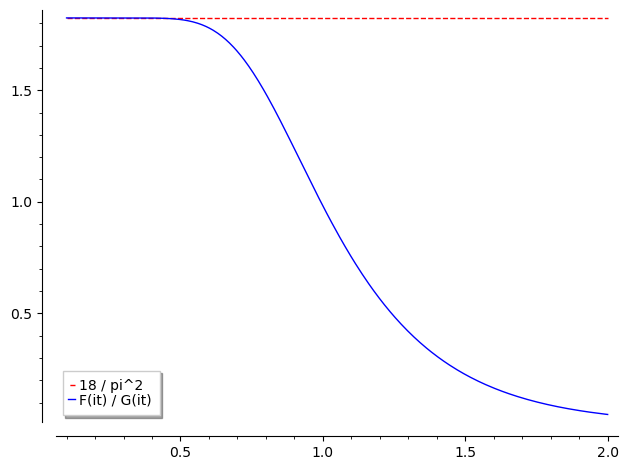

In [20]:
f_8d = qm_to_func(F_8d, prec=100)
g_8d = qm2_to_func(G_8d, prec=100)

q_8d = f_8d / g_8d
lim_8d = 18 / pi^2


p = plot(lim_8d, (t, 0.1, 2.0), color="red", legend_label="18 / pi^2", linestyle="dashed") + \
    plot(q_8d, (t, 0.1, 2.0), color="blue", legend_label="F(it) / G(it)")
show(p)

To prove monotonicity, one needs to prove that $\mathcal{L}_{1, 0} := F'G - FG' = (\partial_{10} F) G - F (\partial_{10}G)$ is positive. We will give two different proofs of this fact, where the second proof will be given after the proof of $d = 24$ case.

First proof uses the fact that $\mathcal{L}_{1, 0}$ nicely factors as
$$
\mathcal{L}_{1, 0} = \frac{15}{2}H_{2}^{3} (H_{2} + H_{4})^{2} H_{4}^{2} (E_{2}E_{4} - E_{6})\left(E_{4} - \frac{1}{2} E_{2}(H_{2} + 2H_{4})\right)
$$
and the last factor can be shown to be positive via the identity
$$
E_4(it) - \frac{1}{2} E_{2}(it) (H_{2}(it) + 2H_{4}(it)) = (E_{4}(it) - E_{4}(2it)) + (E_{4}(2it) - E_{2}(2it)^{2}) + (E_{2}(it) - E_{2}(2it))^{2}.
$$

In [21]:
F_8d_ = l1_to_l2(F_8d)
L_1_0_8d = qm2_serre_derivative(F_8d_, 10) * G_8d - F_8d_ * qm2_serre_derivative(G_8d, 10)
assert L_1_0_8d == qm2_derivative(F_8d_) * G_8d - F_8d_ * qm2_derivative(G_8d)
print_qm2(L_1_0_8d, "L_1,0")

# L_1,0 factors nicely as follows
assert L_1_0_8d == (15/2) * H2^3 * (H2 + H4)^2 * H4^2 * (E2_ * E4_ - E6_) * (E4_ - (1/2) * E2_ * (H2 + 2 * H4))
# The first four factors are positive. The last factor is positive due to the following identity
E2_2 = (1/4) * (H2 + 2 * H4 + 2 * E2_)
E4_2 = (1/4) * (H2 + 2 * H4)^2 - (3/16) * H2^2
assert (E4_ - (1/2) * E2_ * (H2 + 2 * H4)) == (E4_ - E4_2) + (E4_2 - E2_2^2) + (E2_ - E2_2)^2

L_1,0

q_expansion 5308416000*qh^7 + 50960793600*qh^9 + (-528718233600)*qh^11 + (-1961990553600)*qh^13 + 23011983360000*qh^15 + (-22728513945600)*qh^17 + (-168678103449600)*qh^19 + (-25149151641600)*qh^21 + 2255043782246400*qh^23 + (-1339334590464000)*qh^25 + (-14279004153446400)*qh^27 + 15087095827660800*qh^29 + Order(qh^30) 

weight 24
depth 2
cusp order 7/2
polynomial (-15/8) * H4^2 * (H2 + H4)^2 * H2^3 * (-2*H2^2 - 2*H2*H4 - 2*H4^2 + H2*E2 + 2*H4*E2) * (2*H2^3 + 3*H2^2*H4 - 3*H2*H4^2 - 2*H4^3 + 2*H2^2*E2 + 2*H2*H4*E2 + 2*H4^2*E2) 



## $d = 24$

The (quasi)modular forms for the $24$-dimensional magic function are following.

In [22]:
F_24d = 49 * E2^2 * E4^3 - 25 * E2^2 * E6^2 - 48 * E2 * E4^2 * E6 - 25 * E4^4 + 49 * E4 * E6^2
print_qm(F_24d, "F_24d")

G_24d = H2^5 * (2 * H2^2 + 7 * H2 * H4 + 7 * H4^2)
print_qm2(G_24d, "G_24d")

F_24d

q_expansion 3657830400*q^3 + 138997555200*q^4 + 2567796940800*q^5 + 27477621964800*q^6 + 203324160614400*q^7 + 1155903669043200*q^8 + 5339174090342400*q^9 + 21015084264652800*q^10 + 72521005100544000*q^11 + 224861553797529600*q^12 + 636227181370368000*q^13 + 1668067755850137600*q^14 + 4088240185030041600*q^15 + 9465006273911193600*q^16 + 20805434866660147200*q^17 + 43762572956919398400*q^18 + 88336945205133004800*q^19 + O(q^20) 

weight 16
depth 2
cusp order 3
polynomial 49*E2^2*E4^3 - 25*E2^2*E6^2 - 48*E2*E4^2*E6 - 25*E4^4 + 49*E4*E6^2 

G_24d

q_expansion 7340032*qh^5 + 566231040*qh^7 + 14900264960*qh^9 + 202291281920*qh^11 + 1774709637120*qh^13 + 11404383879168*qh^15 + 58038146826240*qh^17 + 246418086297600*qh^19 + 905169579540480*qh^21 + 2953520097525760*qh^23 + 8731672090509312*qh^25 + 23746909873111040*qh^27 + 60124559766978560*qh^29 + Order(qh^30) 

weight 14
depth 0
cusp order 5/2
polynomial H2^5 * (2*H2^2 + 7*H2*H4 + 7*H4^2) 



The following graph supports our idea: the quotient $F(it) / G(it)$ is a decreasing function, and the limit as $t \to 0^+$ is $432 / \pi^2$.

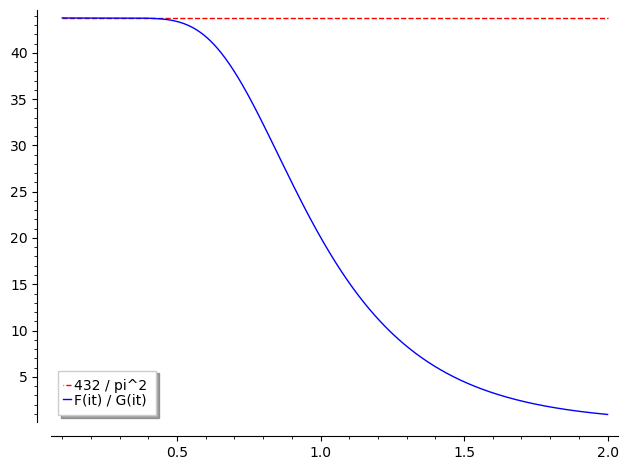

In [23]:
f_24d = qm_to_func(F_24d, prec=100)
g_24d = qm2_to_func(G_24d, prec=100)

q_24d = f_24d / g_24d
lim_24d = 432 / pi^2

p = plot(lim_24d, (t, 0.1, 2.0), color="red", legend_label="432 / pi^2", linestyle="dashed") + \
    plot(q_24d, (t, 0.1, 2.0), color="blue", legend_label="F(it) / G(it)")
show(p)

It is clear from the expression that $G$ is positive. For $F$, the Serre derivative $\partial_{14}F$ of $F$ factors as a product of extremal forms$X_{6,1}$ and $X_{12,1}$, which are both (completely) positive. This implies positivity of $F$.

In [24]:
SF_24d = qm_serre_derivative(F_24d, 14)
print_qm(SF_24d, "S_14(F_24d)")

X_6_1 = extremal_qm(6, 1)
X_12_1 = extremal_qm(12, 1)
print_qm(X_6_1, "X_6,1")
print_qm(X_12_1, "X_12,1")

assert SF_24d == 6706022400 * X_6_1 * X_12_1

S_14(F_24d)

q_expansion 6706022400*q^3 + 496245657600*q^4 + 14042410905600*q^5 + 216792292147200*q^6 + 2187410622566400*q^7 + 16215323107737600*q^8 + 94873425079910400*q^9 + 460862859379507200*q^10 + 1924860638237644800*q^11 + 7100425841338368000*q^12 + 23586538442064998400*q^13 + 71694366272969932800*q^14 + 201781741465304985600*q^15 + 531331202203774156800*q^16 + 1319004010440990720000*q^17 + 3109234547965516185600*q^18 + 6995462883702112512000*q^19 + O(q^20) 

weight 18
depth 2
cusp order 3
polynomial (-7/3) * (-E2*E4 + E6) * (-12*E2*E4*E6 + 5*E4^3 + 7*E6^2) 

X_6,1

q_expansion q + 18*q^2 + 84*q^3 + 292*q^4 + 630*q^5 + 1512*q^6 + 2408*q^7 + 4680*q^8 + 6813*q^9 + 11340*q^10 + 14652*q^11 + 24528*q^12 + 28574*q^13 + 43344*q^14 + 52920*q^15 + 74896*q^16 + 83538*q^17 + 122634*q^18 + 130340*q^19 + O(q^20) 

weight 6
depth 1
cusp order 1
polynomial (-1/720) * (-E2*E4 + E6) 

X_12,1

q_expansion q^2 + 56*q^3 + 1002*q^4 + 9296*q^5 + 57708*q^6 + 269040*q^7 + 1024532*q^8 + 3321024*q^9 + 9542

To prove monotonicity, as $d = 8$ case, one needs to prove that $\mathcal{L}_{1, 0} := F'G - FG' = (\partial_{14} F) G - F (\partial_{14}G)$ is positive. Proof uses the following differential equations satisfied by $F$ and $G$:
$$
\begin{align*}
\partial_{10}^{2}F &= \frac{14}{9} E_4 F + 5486745600 \Delta X_{8, 2} \\
\partial_{10}^{2}G &= \frac{14}{9} E_4 G
\end{align*}
$$
which implies the identity $\partial_{30} \mathcal{L}_{1, 0} = \mathcal{L}_{2, 0} = c\Delta X_{8, 2} G > 0$.

In [25]:
F_24d_ = l1_to_l2(F_24d)
L_1_0_24d = qm2_serre_derivative(F_24d_, 14) * G_24d - F_24d_ * qm2_serre_derivative(G_24d, 14)
assert L_1_0_24d == qm2_derivative(F_24d_) * G_24d - F_24d_ * qm2_derivative(G_24d)
print_qm2(L_1_0_24d, "L_1,0")

# F_24d and G_24d satisfy the following differential identities
c = 5486745600
assert qm_serre_derivative_fold(F_24d, 2, 14) == (14/9) * E4 * F_24d + c * Disc * extremal_qm(8, 2)
assert qm2_serre_derivative_fold(G_24d, 2, 14) == (14/9) * E4_ * G_24d

# Now, take Serre derivative of L_1,0, which gives L_2,0
L_2_0_24d = qm2_serre_derivative_fold(F_24d_, 2, 14) * G_24d - F_24d_ * qm2_serre_derivative_fold(G_24d, 2, 14)
assert qm2_serre_derivative(L_1_0_24d, 30) == L_2_0_24d
assert L_2_0_24d == c * Disc_ * l1_to_l2(extremal_qm(8, 2)) * G_24d

L_1,0

q_expansion 13424296093286400*qh^11 + 494781198866841600*qh^13 + 4717681198497792000*qh^15 + 1434481925396889600*qh^17 + (-154584605027362406400)*qh^19 + (-391694111409910579200)*qh^21 + 1831396170230503833600*qh^23 + 8236035784021377024000*qh^25 + (-6718846770393749913600)*qh^27 + (-83998612909280408371200)*qh^29 + Order(qh^30) 

weight 32
depth 2
cusp order 11/2
polynomial (-105/8) * H4^2 * (H2 + H4)^2 * H2^5 * (-26*H2^7 - 130*H2^6*H4 - 333*H2^5*H4^2 - 536*H2^4*H4^3 - 415*H2^3*H4^4 - 54*H2^2*H4^5 + 112*H2*H4^6 + 32*H4^7 + 20*H2^6*E2 + 90*H2^5*H4*E2 + 96*H2^4*H4^2*E2 - 52*H2^3*H4^3*E2 - 186*H2^2*H4^4*E2 - 192*H2*H4^5*E2 - 64*H4^6*E2 + 46*H2^5*E2^2 + 184*H2^4*H4*E2^2 + 292*H2^3*H4^2*E2^2 + 248*H2^2*H4^3*E2^2 + 80*H2*H4^4*E2^2 + 32*H4^5*E2^2) 



The same approach gives a second proof of $d = 8$ case. The following differential equations satisfied by $F$ and $G$:
$$
\begin{align*}
\partial_{10}^{2}F &= \frac{5}{6} E_4 F + 172800 \Delta X_{4, 2} \\
\partial_{10}^{2}G &= \frac{5}{6} E_4 G - 640 \Delta H_{2}
\end{align*}
$$
which implies the identity $\partial_{22} \mathcal{L}_{1, 0} = \mathcal{L}_{2, 0} = \Delta(172800 X_{4, 2} G + 640 H_2 F) > 0$.

In [26]:
# F_8d and G_8d satisfy the following differential identities
a = 172800
b = 640
assert qm_serre_derivative_fold(F_8d, 2, 10) == (5/6) * E4 * F_8d + a * Disc * extremal_qm(4, 2)
assert qm2_serre_derivative_fold(G_8d, 2, 10) == (5/6) * E4_ * G_8d - b * Disc_ * H2

# Now, take Serre derivative of L_1,0, which gives L_2,0
L_2_0_8d = qm2_serre_derivative_fold(F_8d_, 2, 10) * G_8d - F_8d_ * qm2_serre_derivative_fold(G_8d, 2, 10)
assert qm2_serre_derivative(L_1_0_8d, 22) == L_2_0_8d
assert L_2_0_8d == Disc_ * (a * l1_to_l2(extremal_qm(4, 2)) * G_8d + b * H2 * F_8d_)

For the last inequality, we define auxilary rings
$$
\mathcal{QM}_{w}^{s}(\Gamma)\left[\frac{1}{\pi}, \frac{i}{z}\right]
$$
for $\Gamma = \mathrm{SL}_2(\mathbb{Z})$ and $\Gamma(2)$ (denoted as `RQM` and `RQM2`), and define (Serre) derivatives using
$$
D\left(\frac{1}{\pi}\right) = 0, \quad D\left(\frac{i}{z}\right) = \frac{1}{2\pi i}\frac{\mathrm{d}}{\mathrm{d}z}\left(\frac{i}{z}\right) = \frac{1}{2} \frac{1}{\pi} \left(\frac{i}{z}\right)^{2}
$$
and product rules. Also, we will consider both $1/\pi$ and $i/z$ as weight 1 objects, which makes sense from the transformation law for $E_2$ or other quasimodular forms.

In [27]:
# Level SL_2(Z)
# The following line is needed to fix a bug that `QM` is not belong to a commutative rings,
# see https://ask.sagemath.org/question/76909/ring-of-quasimodular-forms-as-a-commutative-ring/ and https://github.com/sagemath/sage/pull/37797
QM._refine_category_(QM.category().Commutative())  
RQM.<ip, ioz> = QM['ip','ioz']  # `ip` = 1 / pi, `ioz` = i / z


# Weight
def rqm_weight(rqm):
    w = 0
    for (dip, dioz), qm in rqm.dict().items():
        w = max(w, qm.weight() + dip + dioz)
    return w

def is_rqm_homogeneous(rqm):
    w = None
    for (dip, dioz), qm in rqm.dict().items():
        w_ = qm.weight() + dip + dioz
        if w is None:
            w = w_
        else:
            if w != w_:
                return False
    return True

# Depth
def rqm_depth(rqm):
    dp = 0
    for qm in rqm.dict().values():
        dp = max(dp, qm_depth(qm))
    return dp

def rqm_derivative(rqm):
    r = 0
    for (dip, dioz), qm in rqm.dict().items():
        r += qm.derivative() * ip^dip * ioz^dioz
        if dioz >= 1:
            r += qm * ip^dip * dioz * ioz^(dioz - 1) * ((1/2) * ip * ioz^2)
    return r

# Iterative differentiation of quasimodular forms
def rqm_derivative_fold(rqm, k):
    if k == 0:
        return rqm
    else:
        return rqm_derivative_fold(rqm_derivative(rqm), k - 1)

# Serre derivative with given weight k
# If weight is not given, we use k = (weight - depth) that preserves depth.
def rqm_serre_derivative(rqm, k=None):
    if k is None:
        k = rqm_weight(rqm) - rqm_depth(rqm)
    return rqm_derivative(rqm) - E2 * rqm * (k / 12)

# Iterative Serre derivative, which is 
# \partial_{k + 2(r-1)} \circ \partial_{k + 2(r-2)} \circ \cdots \circ \partial_{k} for given r >= 1.
def rqm_serre_derivative_fold(rqm, r, k=None):
    assert r >= 0
    if r == 0:
        return rqm
    elif r == 1:
        return rqm_serre_derivative(rqm, k)
    else:
        if k is None:
            k = rqm_weight(rqm) - rqm_depth(rqm)
        return rqm_serre_derivative(rqm_serre_derivative_fold(rqm, r-1, k), k + 2 * (r-1))

# Print its polynomial form, weight, and depth.
def print_rqm(rqm, name):
    print(name)
    poly_str = ""
    for (dip, dioz), qm in rqm.dict().items():
        if poly_str != "":
            poly_str += " + "
        if dip == 0:
            ip_str = ""
        elif dip == 1:
            ip_str = "*(1/π)"
        else:  # dip >= 2
            ip_str = "*(1/π)^" + str(dip)
        if dioz == 0:
            ioz_str = ""
        elif dioz == 1:
            ioz_str = "*(i/z)"
        else:  # dioz >= 2
            ioz_str = "*(i/z)^" + str(dioz)
        poly_str += "(" + str(qm.polynomial()) + ")" + ip_str + ioz_str
    print("polynomial", poly_str)
    print("weight", rqm_weight(rqm))
    print("depth", rqm_depth(rqm))
    print()

def rqm_to_func(rqm, prec=100):
    t = var('t')
    f = 0
    for (dip, dioz), qm in rqm.dict().items():
        f += (1/pi)^dip * (1/t)^dioz * qm_to_func(qm, prec=prec)
    return f

In [28]:
# Level \Gamma(2)
RQM2.<ip_, ioz_> = QM2['ip','ioz']  # `ip` = 1 / pi, `ioz` = i / z


# Weight
def rqm2_weight(rqm):
    w = 0
    for (dip, dioz), qm in rqm.dict().items():
        w = max(w, qm2_weight(qm) + dip + dioz)
    return w

def is_rqm2_homogeneous(rqm):
    w = None
    for (dip, dioz), qm in rqm.dict().items():
        w_ = qm2_weight(qm) + dip + dioz
        if w is None:
            w = w_
        else:
            if w != w_:
                return False
    return True

# Depth
def rqm2_depth(rqm):
    dp = 0
    for qm in rqm.dict().values():
        dp = max(dp, qm2_depth(qm))
    return dp

def rqm2_derivative(rqm):
    r = 0
    for (dip, dioz), qm in rqm.dict().items():
        r += qm2_derivative(qm) * ip_^dip * ioz_^dioz
        if dioz >= 1:
            r += qm * ip_^dip * dioz * ioz_^(dioz - 1) * ((1/2) * ip_ * ioz_^2)
    return r

# Iterative differentiation of quasimodular forms
def rqm2_derivative_fold(rqm, k):
    if k == 0:
        return rqm
    else:
        return rqm2_derivative_fold(rqm2_derivative(rqm), k - 1)

# Serre derivative with given weight k
# If weight is not given, we use k = (weight - depth) that preserves depth.
def rqm2_serre_derivative(rqm, k=None):
    if k is None:
        k = rqm2_weight(rqm) - rqm2_depth(rqm)
    return rqm2_derivative(rqm) - E2_ * rqm * (k / 12)

# Iterative Serre derivative, which is 
# \partial_{k + 2(r-1)} \circ \partial_{k + 2(r-2)} \circ \cdots \circ \partial_{k} for given r >= 1.
def rqm2_serre_derivative_fold(rqm, r, k=None):
    assert r >= 0
    if r == 0:
        return rqm
    elif r == 1:
        return rqm2_serre_derivative(rqm, k)
    else:
        if k is None:
            k = rqm2_weight(rqm) - rqm2_depth(rqm)
        return rqm2_serre_derivative(rqm2_serre_derivative_fold(rqm, r-1, k), k + 2 * (r-1))

# Print its polynomial form, weight, and depth.
def print_rqm2(rqm, name):
    print(name)
    poly_str = ""
    for (dip, dioz), qm in rqm.dict().items():
        if poly_str != "":
            poly_str += " + "
        if dip == 0:
            ip_str = ""
        elif dip == 1:
            ip_str = "*(1/π)"
        else:  # dip >= 2
            ip_str = "*(1/π)^" + str(dip)
        if dioz == 0:
            ioz_str = ""
        elif dioz == 1:
            ioz_str = "*(i/z)"
        else:  # dioz >= 2
            ioz_str = "*(i/z)^" + str(dioz)
        poly_str += "(" + str(qm) + ")" + ip_str + ioz_str
    print("polynomial", poly_str)
    print("weight", rqm2_weight(rqm))
    print("depth", rqm2_depth(rqm))
    print()

def rqm2_to_func(rqm, prec=100):
    t = var('t')
    f = 0
    for (dip, dioz), qm in rqm.dict().items():
        f += (1/pi)^dip * (1/t)^dioz * qm2_to_func(qm, prec=prec)
    return f

We also define $S$-action on `RQM` and `RQM2`, using the transformation laws of $E_2, E_4, E_6, H_2, H_4$.
Note that, if input is a quasimodular form without any rational terms, then the output is homogeneous (i.e. weights of each terms are all equal).
Otherwise, the output may not be homogeneous in general. Also, we will always assume that the input is homogeneous.
On each monomial, the action $|_{w}S$ on $F \cdot (1/\pi)^{a} \cdot (i/z)^{b}$ where $F \in \mathcal{QM}_{w-a-b}(\Gamma)$ equals
$$
(F|_{w-a-b}S) \cdot (1/\pi)^{a} \cdot (i/(-1/z))^{b} \cdot z^{-a-b} = (-1)^{(a+b)/2} \cdot (F|_{w-a-b}S) \cdot (1/\pi)^{a} \cdot (i/z)^{a}
$$
(we only deal with even weight inputs, so $a + b$ is always even). We can extract homogeneous components using `rqm_homogeneous_comps`.

In [29]:
# S-action. If the input is a purely quasimodular form without rational terms, then the result is homogeneous (in weights).
# Otherwise, the result may not be homogeneous

# Level SL_2(Z)
E2S = E2 - 6 * ip * ioz
E4S = E4
E6S = E6

# For quasimodular forms
def qm_S_action(qm):
    r = 0
    for (d2, d4, d6), coeff in qm.polynomial().dict().items():
        r += coeff * E2S^d2 * E4S^d4 * E6S^d6
    return r

# For homogeneous inputs with rational terms
# For each monomial term rqm = qm * (1/π)^a * (i/z)^b, we get
# rqm|_w,S = qm|_{w-a-b},S * (1/π)^a * (z/i)^b * z^(-a-b) = (-1)^((a + b)/2) * qm|_{w-a-b},S * (1/π)^a * (i/z)^a
def rqm_S_action(rqm):
    r = 0
    assert is_rqm_homogeneous(rqm), "Input is not homogeneous."
    for (dip, dioz), qm in rqm.dict().items():
        r += (-1)^((dip + dioz)/2) * qm_S_action(qm) * ip^dip * ioz^dip
    return r

# Level Gamma(2)
H2S = -H4
H4S = -H2
E2S_ = E2_ - 6 * ip_ * ioz_

# For quasimodular forms
def qm2_S_action(qm):
    r = 0
    for (dh2, dh4, de2), coeff in qm.dict().items():
        r += coeff * H2S^dh2 * H4S^dh4 * E2S_^de2
    return r

# For homogeneous inputs with rational terms
# For each monomial term rqm = qm * (1/π)^a * (i/z)^b, we get
# rqm|_w,S = qm|_{w-a-b},S * (1/π)^a * (-iz)^b * z^(-a-b) = (-1)^b * qm|_{w-a-b},S * (1/π)^a * (i/z)^a
def rqm2_S_action(rqm):
    r = 0
    assert is_rqm2_homogeneous(rqm), "Input is not homogeneous."
    for (dip, dioz), qm in rqm.dict().items():
        r += (-1)^((dip + dioz)/2) * qm2_S_action(qm) * ip_^dip * ioz_^dip
    return r

# Extract each of homogeneous components
def rqm_homogeneous_comps(rqm):
    r = dict()
    for (dip, dioz), qm in rqm.dict().items():
        qm_comps = qm.homogeneous_components()
        for w_, qm_ in qm_comps.items():
            w = w_ + dip + dioz
            if w not in r:
                r[w] = qm_ * ip^dip * ioz^dioz
            else:
                r[w] += qm_ * ip^dip * ioz^dioz
    return r

def qm2_homogeneous_comps(qm):
    r = dict()
    for (dh2, dh4, de2), coeff in qm.dict().items():
        w = 2 * (dh2 + dh4 + de2)
        if w not in r:
            r[w] = coeff * H2^dh2 * H4^dh4 * E2_^de2
        else:
            r[w] += coeff * H2^dh2 * H4^dh4 * E2_^de2
    return r

def rqm2_homogeneous_comps(rqm):
    r = dict()
    for (dip, dioz), qm in rqm.dict().items():
        qm_comps = qm2_homogeneous_comps(qm)
        for w_, qm_ in qm_comps.items():
            w = w_ + dip + dioz
            if w not in r:
                r[w] = qm_ * ip_^dip * ioz_^dioz
            else:
                r[w] += qm_ * ip_^dip * ioz_^dioz
    return r

At last, the following function embeds `RQM` into `RQM2`.

In [30]:
# embed RQM \to RQM2
def rqm_to_rqm2(rqm):
    r = 0
    for (dip, dioz), qm in rqm.dict().items():
        r += l1_to_l2(qm) * ip_^dip * ioz_^dioz
    return r

Before we proceed to the last inequality, we'll show how to use the above $S$-action functions to compute the limits appearing in the previous (and also in upcoming) inequalities.
For $8$-dimensional case, one needs to prove
$$
\lim_{t \to 0^+} \frac{F(it)}{G(it)} = \frac{18}{\pi^2},
$$
and this can be proven by rewriting it as
$$
\lim_{t \to \infty} \frac{F(i/t)}{G(i/t)} = \lim_{t \to \infty} \frac{t^{12}(F|_{12}S)(it)}{-t^{10}(G|_{10}S)(it)} = \lim_{t \to \infty} - t^{2} \frac{(F|_{12}S)(it)}{(G|_{10}S)(it)}.
$$
We can compute the numerator and the denominator and deduce the limit as in the paper.

In [31]:
F_8dS = qm_S_action(F_8d)
G_8dS = qm2_S_action(G_8d)

print_rqm(F_8dS, "F_8d|S")
print_rqm2(G_8dS, "G_8d|S")

# The modular components of F_8dS for ip^0 * ioz^0 and ip^1 * ioz^1 are both cusp forms, hence does not contribute to the limit
print("F_8dS, ip^0 * ioz^0:", F_8dS.coefficient([0, 0]))
print("F_8dS, ip^1 * ioz^1:", F_8dS.coefficient([1, 1]))
print("F_8dS, ip^2 * ioz^2:", F_8dS.coefficient([2, 2]))

print("G_8dS, ip^0 * ioz^0:", qm2_q_series(QM2(G_8dS.coefficient([0, 0])), 10))

F_8d|S
polynomial (E2^2*E4^2 - 2*E2*E4*E6 + E6^2) + (-12*E2*E4^2 + 12*E4*E6)*(1/π)*(i/z) + (36*E4^2)*(1/π)^2*(i/z)^2
weight 12
depth 2

G_8d|S
polynomial (-5*H2^2*H4^3 - 5*H2*H4^4 - 2*H4^5)
weight 10
depth 0

F_8dS, ip^0 * ioz^0: 518400*q^2 + 18662400*q^3 + 255052800*q^4 + 1870387200*q^5 + O(q^6)
F_8dS, ip^1 * ioz^1: -8640*q - 2229120*q^2 - 56712960*q^3 - 570689280*q^4 - 3375043200*q^5 + O(q^6)
F_8dS, ip^2 * ioz^2: 36 + 17280*q + 2229120*q^2 + 37808640*q^3 + 285344640*q^4 + 1350017280*q^5 + O(q^6)
G_8dS, ip^0 * ioz^0: (-2) + (-240)*qh^2 + 10240*qh^3 + (-134640)*qh^4 + 1007616*qh^5 + (-5215680)*qh^6 + 20828160*qh^7 + (-69131760)*qh^8 + 199966720*qh^9 + Order(qh^10)


We can proceed for $24$-dimension case similarly and get
$$
\lim_{t \to 0^+} \frac{F(it)}{G(it)} = \frac{432}{\pi^2}.
$$

In [32]:
F_24dS = qm_S_action(F_24d)
G_24dS = qm2_S_action(G_24d)

print_rqm(F_24dS, "F_24d|S")
print_rqm2(G_24dS, "G_24d|S")

# The modular components of F_24dS for ip^0 * ioz^0 and ip^1 * ioz^1 are both cusp forms, hence does not contribute to the limit
print("F_24dS, ip^0 * ioz^0:", F_24dS.coefficient([0, 0]))
print("F_24dS, ip^1 * ioz^1:", F_24dS.coefficient([1, 1]))
print("F_24dS, ip^2 * ioz^2:", F_24dS.coefficient([2, 2]))

print("G_24dS, ip^0 * ioz^0:", qm2_q_series(QM2(G_24dS.coefficient([0, 0])), 10))

F_24d|S
polynomial (49*E2^2*E4^3 - 25*E2^2*E6^2 - 48*E2*E4^2*E6 - 25*E4^4 + 49*E4*E6^2) + (-588*E2*E4^3 + 300*E2*E6^2 + 288*E4^2*E6)*(1/π)*(i/z) + (1764*E4^3 - 900*E6^2)*(1/π)^2*(i/z)^2
weight 16
depth 2

G_24d|S
polynomial (-7*H2^2*H4^5 - 7*H2*H4^6 - 2*H4^7)
weight 14
depth 0

F_24dS, ip^0 * ioz^0: 3657830400*q^3 + 138997555200*q^4 + 2567796940800*q^5 + O(q^6)
F_24dS, ip^1 * ioz^1: -725760*q - 78382080*q^2 - 15040650240*q^3 - 454261893120*q^4 - 6683835916800*q^5 + O(q^6)
F_24dS, ip^2 * ioz^2: 864 + 2177280*q + 117573120*q^2 + 15040650240*q^3 + 340696419840*q^4 + 4010301550080*q^5 + O(q^6)
G_24dS, ip^0 * ioz^0: (-2) + 560*qh^2 + (-196560)*qh^4 + 3670016*qh^5 + (-38445120)*qh^6 + 283115520*qh^7 + (-1608122320)*qh^8 + 7450132480*qh^9 + Order(qh^10)


Now, let's return to the last inequality. Our main observation is that the function
$$
g(t) := \frac{432}{\pi^2} - \frac{F(it)}{G(it)} - 725760 \frac{\Delta(it)}{G(it)} \left(\frac{1}{\pi t^3} - \frac{10}{3 \pi^2 t^2}\right)
$$
is monotone increasing in $t$ for $0 < t < \frac{3\pi}{10}$, and its limit as $t \to 0^+$ equals to $0$.

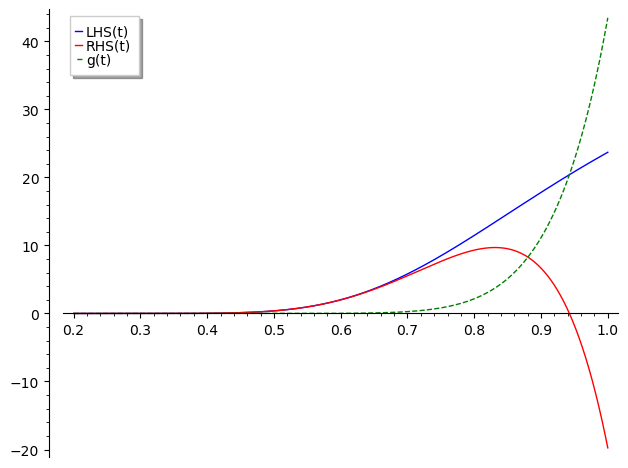

In [33]:
disc = qm_to_func(Disc)
LHS_func = 432 / pi^2 - f_24d / g_24d
RHS_func = 725760 * disc / g_24d * (1 / pi / t^3 - (10/3) / pi^2 / t^2)
g_func = LHS_func - RHS_func

show(
    plot(LHS_func, (t, 0.2, 1.0), color="blue", legend_label="LHS(t)") + \
    plot(RHS_func, (t, 0.2, 1.0), color="red", legend_label="RHS(t)") + \
    plot(g_func, (t, 0.2, 1.0), color="green", linestyle="dashed", legend_label="g(t)")
)

The limit part can be computed using the trick $\lim_{t \to 0^+} g(t) = \lim_{t \to \infty} g(1/t)$ as before. Since we already know $\lim_{t \to 0^+} \frac{432}{\pi^{2}} - \frac{F(it)}{G(it)} = 0$, it is enough to show that
$$
\lim_{t \to 0^+} \frac{\Delta(it)}{G(it)} \left(\frac{1}{\pi t^3} - \frac{10}{\pi^2 t^2}\right) = \lim_{t \to \infty} \frac{\Delta(i/t)}{G(i/t)} \left(\frac{t^3}{\pi} - \frac{10 t^{2}}{\pi^{2}}\right) = \lim_{t \to \infty} \frac{(\Delta|_{12}S)(it)}{-t^{2} (G|_{14}S)(it)} \left(\frac{t^3}{\pi} - \frac{10 t^{2}}{\pi^{2}}\right) = \lim_{t \to \infty} \frac{(\Delta|_{12}S)(it)}{- (G|_{14}S)(it)} \left(\frac{t}{\pi} - \frac{10 }{\pi^{2}}\right)
$$
equals $0$, which is true since $\Delta|_{12}S = \Delta$ is a cusp form and $G|_{14}S$ is not.

In [34]:
DiscS = qm_S_action(Disc)
assert DiscS == Disc
print("Disc:", Disc)
print("G_24d|S:", qm2_q_series(QM2(G_24dS.coefficient([0, 0])), 10))

Disc: q - 24*q^2 + 252*q^3 - 1472*q^4 + 4830*q^5 + O(q^6)
G_24d|S: (-2) + 560*qh^2 + (-196560)*qh^4 + 3670016*qh^5 + (-38445120)*qh^6 + 283115520*qh^7 + (-1608122320)*qh^8 + 7450132480*qh^9 + Order(qh^10)


For the monotonicity part, $\mathrm{d}g / \mathrm{d}t > 0$ is equivalent to
$$
\widetilde{\mathcal{L}}_{1, 0}(it) := \mathcal{L}_{1, 0}(it) - 725760 \Delta(it) \left[(\partial_{12}G)(it) \left(\frac{1}{\pi t^3} - \frac{10}{3 \pi^2 t^2}\right) - G(it) \left(\frac{3}{2 \pi^2 t^4} - \frac{10}{3 \pi^3 t^3} \right)\right] > 0.
$$
To prove this, we first check $\widetilde{\mathcal{L}}_{1, 0}\left(\frac{3\pi i}{10}\right) > 0$, and show $\partial_{30}\widetilde{\mathcal{L}}_{1, 0}(it) > 0$ on $0 < t < \frac{3\pi}{10}$.
We set $p = p(t) = \frac{1}{\pi t^3} - \frac{10}{\pi^2 t^2}$ so
$$
\begin{align*}
Dp &= -\frac{1}{2\pi} \frac{\mathrm{d}p}{\mathrm{d}t} = \frac{3}{2 \pi^2 t^4} - \frac{10}{\pi^3 t^3}, \\
D^{2}p &= \frac{1}{4\pi^2} \frac{\mathrm{d}^{2}p}{\mathrm{d}t^2} = \frac{3}{\pi^3 t^5} - \frac{5}{\pi^4 t^4},
\end{align*}
$$
then we get
$$
\partial_{30} \widetilde{\mathcal{L}}_{1, 0} = 725760 \Delta G\left[ 7560 X_{8, 2} - \left(\frac{37 E_4 - E_2^2}{24}\right) \cdot p - \frac{1}{2}E_2 \cdot Dp + D^{2}p \right].
$$

In [35]:
p = ip * ioz^3 - (10/3) * ip^2 * ioz^2
Dp = rqm_derivative(p)  # (3/2) * ip^2 * ioz^4 - (10/3) * ip^3 * ioz^3
DDp = rqm_derivative(Dp)  # 3 * ip^3 * ioz^5 - 5 * ip^4 * ioz^4
print_rqm(Dp, "Dp")
print_rqm(DDp, "DDp")
p_ = rqm_to_rqm2(p)
Dp_ = rqm_to_rqm2(Dp)
DDp_ = rqm_to_rqm2(DDp)
X82 = extremal_qm(8, 2)

Ltilde = L_1_0_24d - 725760 * Disc_ * (qm2_serre_derivative(G_24d, 12) * p_ - G_24d * Dp_)
S30Ltilde = rqm2_serre_derivative(Ltilde, 30)
h = 7560 * X82 - ((37 * E4 - E2^2) / 24) * p - (E2 / 2) * Dp + DDp
h_ = rqm_to_rqm2(h)
assert S30Ltilde == 725760 * Disc_ * G_24d * h_

Dp
polynomial (3/2)*(1/π)^2*(i/z)^4 + (-10/3)*(1/π)^3*(i/z)^3
weight 6
depth 0

DDp
polynomial (3)*(1/π)^3*(i/z)^5 + (-5)*(1/π)^4*(i/z)^4
weight 8
depth 0



So it is enough to show that the factor
$$
h = h(t) := 7560 X_{8, 2}(it) - \left(\frac{37 E_4(it) - E_2(it)^2}{24}\right) \cdot p - \frac{1}{2}E_2(it) \cdot Dp + D^{2}p 
$$
is positive on $0 < t < \frac{3\pi}{10}$, which is equivalent to proving
$$
\begin{align*}
(h|_{8, S})(t) &= t^{-8} h\left(\frac{1}{t}\right) \\
&= 7560 X_{8, 2}(it) \\
&\quad + \frac{1}{\pi t} \left(\frac{7 E_2(it) E_4(it) - E_6(it)}{4} - \frac{37 E_4(it) - E_2(it)^{2}}{24}\right) + \frac{1}{\pi^{2} t^{2}} \left(- \frac{4 E_4(it) + 5E_2(it)^{2}}{36} + \frac{E_2(it)}{4}\right) > 0
\end{align*}
$$
for $t > \frac{10}{3 \pi}$. One can actually prove that the last line (`hS2` below) is positive.

h
polynomial (-7/48*E2^2*E4 + 1/24*E2*E6 + 5/48*E4^2) + (1/24*E2^2 - 37/24*E4)*(1/π)*(i/z)^3 + (-5/36*E2^2 + 185/36*E4)*(1/π)^2*(i/z)^2 + (-3/4*E2)*(1/π)^2*(i/z)^4 + (5/3*E2)*(1/π)^3*(i/z)^3 + (3)*(1/π)^3*(i/z)^5 + (-5)*(1/π)^4*(i/z)^4
weight 8
depth 2

weight 8 component
polynomial (-7/48*E2^2*E4 + 1/24*E2*E6 + 5/48*E4^2) + (7/4*E2*E4 - 1/4*E6)*(1/π)*(i/z) + (-5/36*E2^2 - 1/9*E4)*(1/π)^2*(i/z)^2
weight 8
depth 2

weight 6 component
polynomial (1/24*E2^2 - 37/24*E4)*(1/π)*(i/z) + (1/4*E2)*(1/π)^2*(i/z)^2
weight 6
depth 2



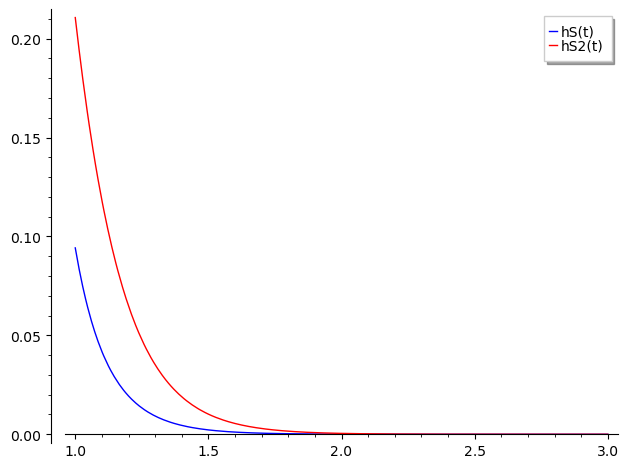

In [36]:
print_rqm(h, "h")
hS = rqm_S_action(h)
hS_comps = rqm_homogeneous_comps(hS)
for k in hS_comps:
    print_rqm(hS_comps[k], "weight " + str(k) + " component")

assert hS == 7560 * X82 + ip * ioz * ((7 * E2 * E4 - E6) / 4 - (37 * E4 - E2^2) / 24) + ip^2 * ioz^2 * (-(4*E4+5*E2^2)/36 + E2 / 4)

hS2 = ((7 * E2 * E4 - E6) / 4 - (37 * E4 - E2^2) / 24) + ip * ioz * (-(4*E4+5*E2^2)/36 + E2 / 4)
assert hS == 7560 * X82 + ip * ioz * hS2

show(
    plot(rqm_to_func(hS), (t, 1.0, 3.0), legend_label="hS(t)") + \
    plot(rqm_to_func(hS2), (t, 1.0, 3.0), color="red", legend_label="hS2(t)")
)

J1

q_expansion 26*q + 318*q^2 + 1224*q^3 + 3302*q^4 + 6396*q^5 + 12312*q^6 + 18448*q^7 + 30390*q^8 + 40818*q^9 + 60948*q^10 + 74712*q^11 + 109368*q^12 + 124684*q^13 + 172464*q^14 + 197424*q^15 + 261206*q^16 + 282708*q^17 + 380934*q^18 + 396520*q^19 + O(q^20) 

weight [2, 4]
depth 2
cusp order 1
polynomial (1/36) * (5*E2^2 + 4*E4 - 9*E2) 

J2

q_expansion 480*q + 16560*q^2 + 122880*q^3 + 532560*q^4 + 1575360*q^5 + 4057920*q^6 + 8471040*q^7 + 17047440*q^8 + 29883360*q^9 + 51991200*q^10 + 81169920*q^11 + 129984960*q^12 + 187131840*q^13 + 279550080*q^14 + 384422400*q^15 + 545529360*q^16 + 715608000*q^17 + 986160240*q^18 + 1247953920*q^19 + O(q^20) 

weight [2, 6]
depth 1
cusp order 1
polynomial (-1) * (E6 - E2) 

J3

q_expansion 252/5*q - 19764/5*q^2 - 281232/5*q^3 - 1424916/5*q^4 - 4957848/5*q^5 - 13090896/5*q^6 - 29823264/5*q^7 - 12099780*q^8 - 110767284/5*q^9 - 194363064/5*q^10 - 313957296/5*q^11 - 498842064/5*q^12 - 741602232/5*q^13 - 1105283232/5*q^14 - 1543201632/5*q^15 - 2190315348

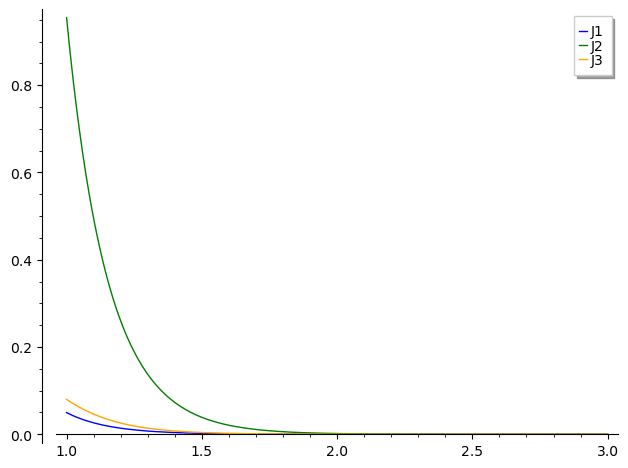

In [37]:
# hS2 is positive
J1 = (5 * E2^2 + 4 * E4) / 36 - E2 / 4
J2 = E2 - E6
J3 = E2 * E4 - E6 / 10 - (9 / 10) * E4
print_qm(J1, "J1")
print_qm(J2, "J2")
print_qm(J3, "J3")
assert hS2 == (3/10 - ip * ioz) * J1 + (3/40) * J2 + (7/4) * J3
assert J1 == (5/3) * E2.derivative() - (1/4) * E2 + (1/4) * E4
assert J3 == 3 * E4.derivative() + (9/10) * E6 - (9/10) * E4

low_t = 1
high_t = 3.0
plots = [
    plot(qm_to_func(J1), (t, low_t, high_t), legend_label="J1"),
    plot(qm_to_func(J2), (t, low_t, high_t), color="green", legend_label="J2"),
    plot(qm_to_func(J3), (t, low_t, high_t), color="orange", legend_label="J3"),
]
show(sum(plots))

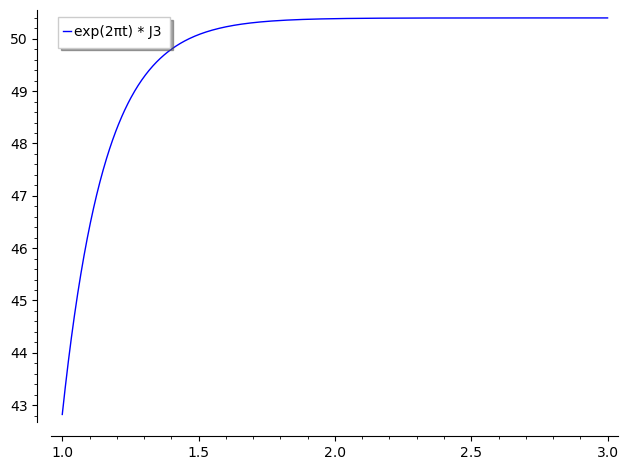

In [38]:
show(plot(exp(2*pi*t) * qm_to_func(J3), (t, low_t, high_t), legend_label="exp(2πt) * J3"))  # monotone increasing